In [23]:
import xarray as xr, matplotlib, matplotlib.pyplot as plt, cartopy, pandas as pd, numpy as np, re, glob, os, geopandas as gpd, regionmask
xr.set_options(keep_attrs = True)
matplotlib.rcParams['savefig.bbox'] = "tight"

from dateutil.relativedelta import relativedelta
from datetime import datetime, timedelta

from xarray.groupers import BinGrouper
from xhistogram.xarray import histogram

from IPython.display import clear_output

from geopy.geocoders import Nominatim

import statsmodels.nonparametric.smoothers_lowess as sm_lowess       # nonparametric smoother

mapproj = cartopy.crs.PlateCarree()

In [2]:
sf_n = gpd.read_file("sf_northern")
sf_s = gpd.read_file("sf_southern")

ERROR 1: PROJ: proj_create_from_database: Open of /rds/general/user/cb2714/home/miniforge3/envs/wwa/share/proj failed


# Map of impacted regions

Cyclone Harry
- Southern Italy, esp Sicily, Sardinia, Calabria: damage to railways, port infrastructure, homes, businesses; disruption to transport; school and public buildings closures

Storm Kristin
- Portugal, esp Centro region and Lisbon metro area: damage to buildings, airplanes, schurches, schools, factories, power outages
- Spain, esp Andalusia region: Power outages affecting 150k buildings

Storm Leonardo
- Spain, esp Cadiz, Andalusia, Malaga: two fatalities, port disruption and closures, school closures
- Gibraltar: Port closures
- Morocco, esp Larache province: four fatalities
- Portugal, esp in Alentejo region: one fatality

Storm Marta
- Portugal, esp Algarve region, Atlantic coast: inundation and erosion, harbor and beach closures, rail suspensions, “catastrophic” crop damage
- Spain, esp Andalusia region, Avila province, Extremadura region: “catastrophic” crop damage, evacuations of tens of thousands, over 100 road closures, beach closures
- Morocco, esp Tangier, Sale, Casablanca: homes destroyed, four deaths

Storm Nils
- Italy, esp Sardinia, Lazio, Calabria: traffic disruption
- France, esp Nouvelle-Aquitaine, Occitaine: two fatalities, power outages for nearly 900k buildings, transport disruptions, school closures, ski resort closures
- Spain, esp Catalonia region, Galicia, Basque Country, Cantabria: one fatality, flight, rail and road suspensions and cancellations, school closures, sports suspensions, injuries

Storm Oriane
- Portugal: evacuations, transport disruptions
- Spain, esp Basque, Cadiz, Catalonia, Balearic islands, Madrid, Murcia: injuries, infrastructural damage

In [ ]:
# list of storms
storms = {"Harry" : {"dates" : slice("2026-01-19", "2026-01-20"),
                     "sites" : ["Sardinia", "Sicily", "Calabria", "Corsica", "Emporda", "Valencia", "Barcelona",  "Sidi Bou Said"]},
          "Kristin" : {"dates" : slice("2026-01-27", "2026-01-29"),
                       "sites" : ["Centro, Portugal", "Lisbon", "Andalusia"]},
          "Leonardo" : {"dates" : slice("2026-02-04", "2026-02-04"),
                       "sites" : ["Cadiz, Spain", "Andalusia", "Malaga", "Gibraltar", "Larache", "Alentejo"]},
          "Marta" : {"dates" : slice("2026-02-07", "2026-02-07"),
                       "sites" : ["Algarve", "Avila", "Extremadura", "Tangier", "Sale, Morocco", "Casablanca", "Serranía de Ronda"]},
          "Nils" : {"dates" : slice("2026-02-12", "2026-02-12"),
                       "sites" : ["Landes", "Galicia", "Basque Country", "Cantabria", "Barcelona", "Tarn-et-Garonne"]},
          "Oriana" : {"dates" : slice("2026-02-13", "2026-02-13"),
                       "sites" : ["Basque Country", "Ibiza", "Cadiz, Spain", "Catalonia", "Madrid", "Murcia"]}
          }

# convert to dataframe
storm_df = pd.concat([pd.DataFrame([[storm, d, s] for d in pd.date_range(info["dates"].start, info["dates"].stop) for s in info["sites"]]) for storm, info in storms.items()])
storm_df.columns = ["storm", "date", "site"]
storm_df = storm_df.set_index("date")

In [8]:
def get_latlon(city):
    
    # retrieve lat & lon for given location
    location = Nominatim(user_agent="GetLoc").geocode(city)
    if location is None:
        return {"lon" : None, "lat" : None}
    else:
        return {"lon" : location.longitude, "lat" : location.latitude}

In [9]:
# get list of points
px = pd.DataFrame({s : get_latlon(s) for s in list(set(storm_df.site))}).transpose()
px.to_csv("med-storms_reported-impacts.csv")

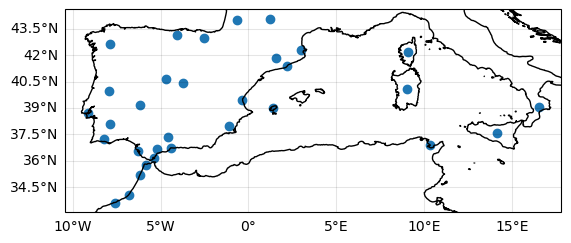

In [10]:
# map of locations mentioned
fig, ax = plt.subplots(subplot_kw = {"projection" : mapproj})

ax.scatter(px.lon, px.lat)
ax.coastlines()

ax.gridlines(color = "k", alpha = 0.1, draw_labels = ["bottom", "left"])

In [22]:
pr = xr.open_mfdataset("/rds/general/user/cb2714/home/00_WWA_project_folder/live/data/mswep/2026/*.nc").precipitation.sel(lon = slice(-10,20), lat = slice(46,33)).load()
pr = pr.sel(time = slice("2026-01-17", "2026-02-13"))

In [25]:
rm = regionmask.defined_regions.natural_earth_v5_1_2.land_50.mask(pr)
pr = pr.where(rm == 0)

In [ ]:
# pr = xr.open_dataset("data/pr_mswep_-10_5_30_45.nc").precipitation.sel(time = slice("2026-01-17", None))

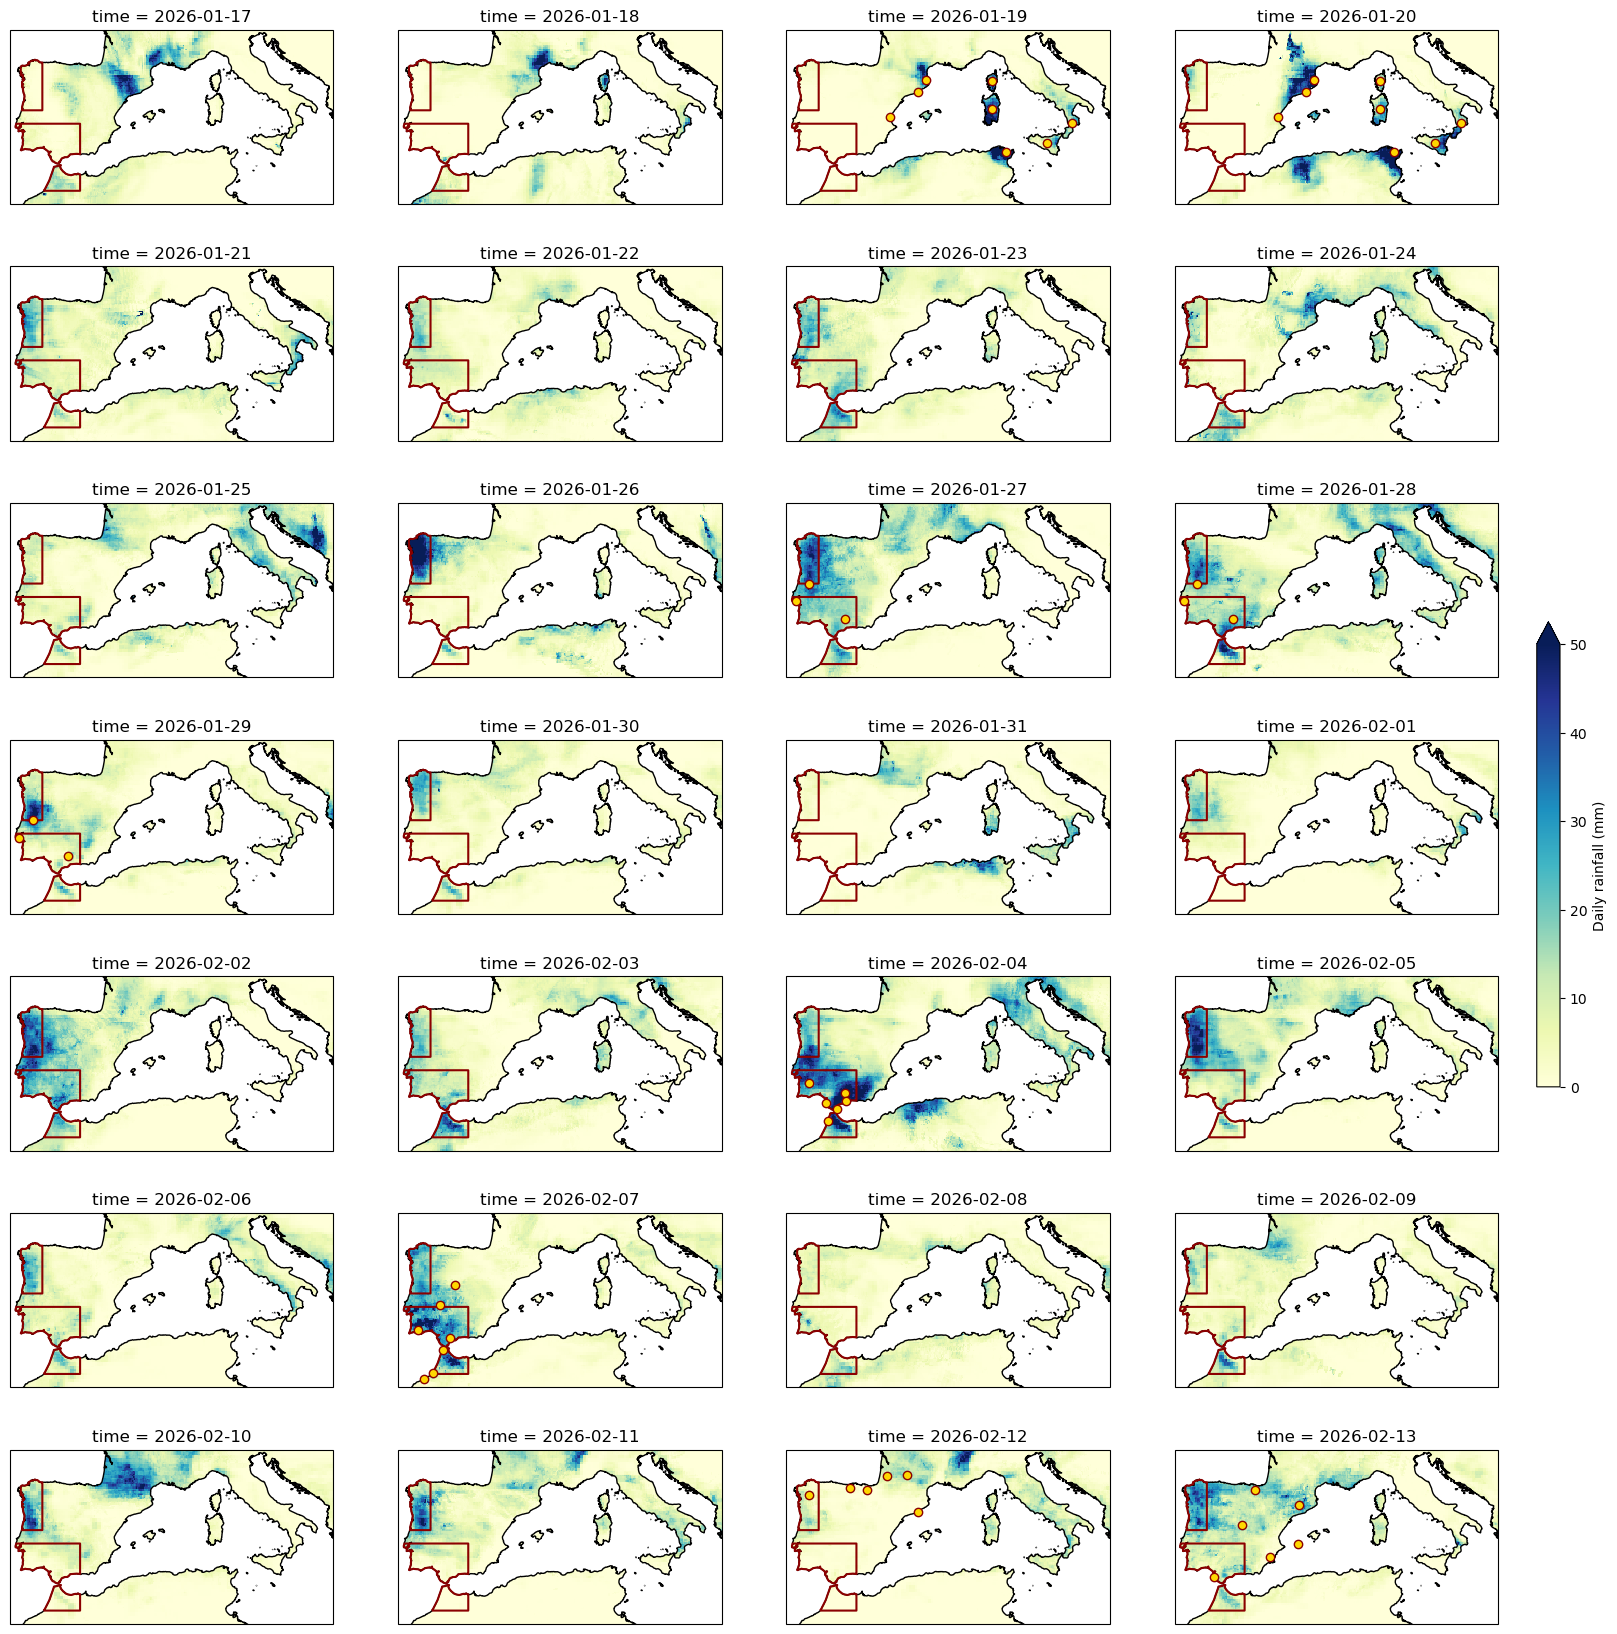

In [26]:
nc = 4; nr = int(np.ceil(len(pr.time)/nc))
fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc * 5, nr * 3), subplot_kw = {"projection" : mapproj})

for i in range(len(pr.time)):
    ax = axs.flatten()[i]
    cbar = pr.isel(time = i).plot(ax = ax, cmap = "YlGnBu", vmax = 50, vmin = 0, add_colorbar = False)
    ax.coastlines()
    sf_n.boundary.plot(ax = ax, color = "darkred")
    sf_s.boundary.plot(ax = ax, color = "darkred")

    if pr.time.values[i] in storm_df.index:
        px_d = px.loc[storm_df.loc[pr.time.values[i], "site"]]
        ax.scatter(px_d.lon, px_d.lat, marker = "o", ec = "darkred", facecolor = "gold", zorder = 99)

plt.colorbar(cbar, ax = axs, fraction = 0.015, pad = 0.025, label = "Daily rainfall (mm)", extend = "max")

plt.savefig("fig/stampplots-daily_mswep.png")

# NAO

## Compare versions

In [215]:
nao_stn = pd.read_csv("data/nao-stn_monthly_ucar.csv", index_col = 0, parse_dates = [0]).rename(columns = {"nao" : "nao_stn"})
nao_pc = pd.read_csv("data/nao-pc_monthly_noaa.csv", index_col = 0, parse_dates = [0]).rename(columns = {"nao" : "nao_pc"})

nao = pd.merge(nao_stn, nao_pc, left_index = True, right_index = True)

In [216]:
nao.corr()

,nao_stn,nao_pc
nao_stn,1.000000,0.691579
nao_pc,0.691579,1.000000


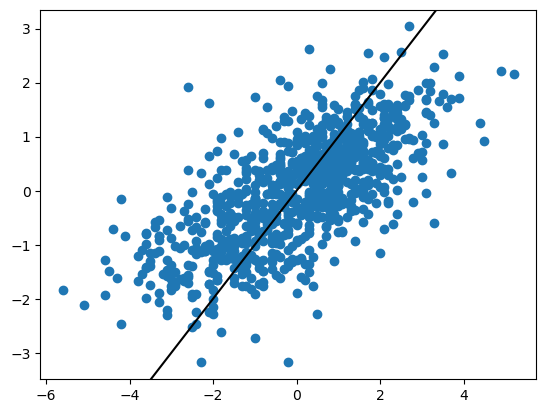

In [217]:
plt.scatter(nao.nao_stn, nao.nao_pc)
plt.axline((0,0), slope = 1, color = "k")

In [218]:
nao_era5 = pd.read_csv("data/nao-stn_monthly_era5.csv", index_col = 0, parse_dates = [0]).rename(columns = {"nao" : "nao_era5"})

In [219]:
nao = pd.merge(nao, nao_era5, left_index = True, right_index = True)

In [220]:
nao.corr()

,nao_stn,nao_pc,msl
nao_stn,1.000000,0.691579,0.861463
nao_pc,0.691579,1.000000,0.692959
msl,0.861463,0.692959,1.000000


In [221]:
nao_djf = nao.loc[nao.index.month.isin([1,2,12])].resample("YE-FEB").mean()
nao_djf.index = nao_djf.index.year

gmst = pd.read_csv("ts/gmst.dat", comment = "#", sep = " +", engine = "python", header = None, names = ["year", "gmst"], index_col = "year")

In [222]:
# station index is much less correlated with GMST
pd.merge(gmst, nao_djf, left_index = True, right_index = True).corr()

,gmst,nao_stn,nao_pc,msl
gmst,1.000000,0.282549,0.450690,0.289233
nao_stn,0.282549,1.000000,0.910448,0.985477
nao_pc,0.450690,0.910448,1.000000,0.914968
msl,0.289233,0.985477,0.914968,1.000000


In [223]:
gmst_coeffs = (nao_djf.to_xarray().assign_coords(index = gmst.loc[nao_djf.index].gmst)).polyfit("index", deg = 1)
gmst_fitted = xr.polyval(gmst.to_xarray().gmst, gmst_coeffs)

<Axes: >

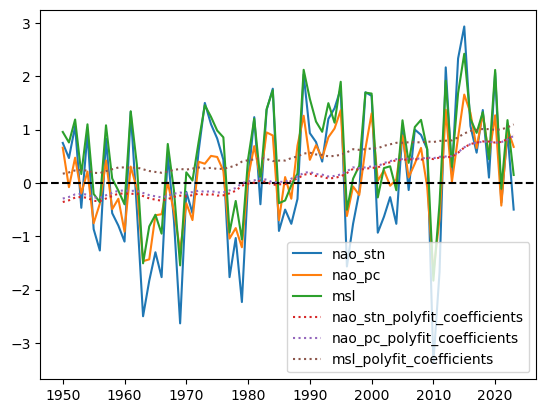

In [224]:
nao_djf.plot()
plt.axhline(0, color = "k", ls = "--")

gmst_fitted.to_dataframe().loc[nao_djf.index].plot(ax = plt.gca(), ls = ":")

In [225]:
#but actually we have a much longer time series from the station version, although it doesn't span to 2026
naos_djf = nao_stn.loc[nao_stn.index.month.isin([1,2,12])].resample("YE-FEB").mean()
naos_djf.index = naos_djf.index.year

gmst_coeffs2 = (naos_djf.loc[slice("1879",None)].to_xarray().assign_coords(index = gmst.loc[slice(None, 2023)].gmst)).polyfit("index", deg = 1)
gmst_fitted2 = xr.polyval(gmst.loc[slice(None, 2023)].to_xarray().gmst, gmst_coeffs2)

pd.merge(gmst, naos_djf, left_index = True, right_index = True).corr()

,gmst,nao_stn
gmst,1.000000,0.116123
nao_stn,0.116123,1.000000


<Axes: xlabel='year'>

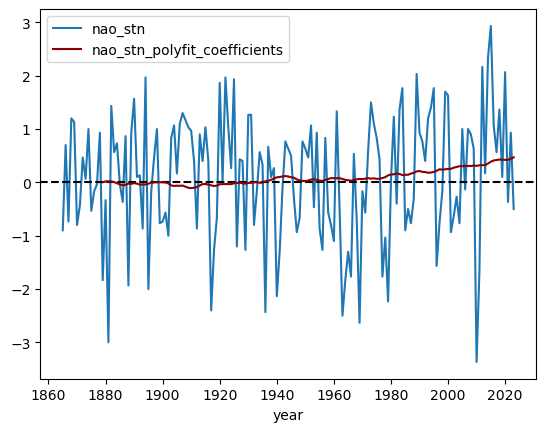

In [226]:
naos_djf.plot()
plt.axhline(0, color = "k", ls = "--")

gmst_fitted2.to_dataframe().plot(ax = plt.gca(), color = "darkred")

# Exploration of time series


## Check similarity / quality control

In [14]:
rnm = "s"

ts = xr.concat([xr.open_dataset(fnm).expand_dims(ds = [fnm.split("_")[1][:-3]]) for fnm in sorted(glob.glob("data/pr-"+rnm+"_*.nc"))], "ds").pr

rx1day = ts.sel(time = ts.time.dt.month.isin([12,1,2])).resample(time = "YE-MAR").max()

In [5]:
ts.sel(time = slice("2025","2026")).to_pandas().transpose().corr()

ds,chirps,cpc,eobs,era5,mswep
ds,,,,,
chirps,1.000000,0.726296,0.701454,0.757597,0.797861
cpc,0.726296,1.000000,0.832804,0.947728,0.951278
eobs,0.701454,0.832804,1.000000,0.889162,0.888403
era5,0.757597,0.947728,0.889162,1.000000,0.963309
mswep,0.797861,0.951278,0.888403,0.963309,1.000000


In [6]:
rx1day.to_pandas().transpose().corr()

ds,chirps,cpc,eobs,era5,mswep
ds,,,,,
chirps,1.000000,0.602913,0.606195,0.802345,0.778514
cpc,0.602913,1.000000,0.748216,0.825758,0.875338
eobs,0.606195,0.748216,1.000000,0.675338,0.744511
era5,0.802345,0.825758,0.675338,1.000000,0.894358
mswep,0.778514,0.875338,0.744511,0.894358,1.000000


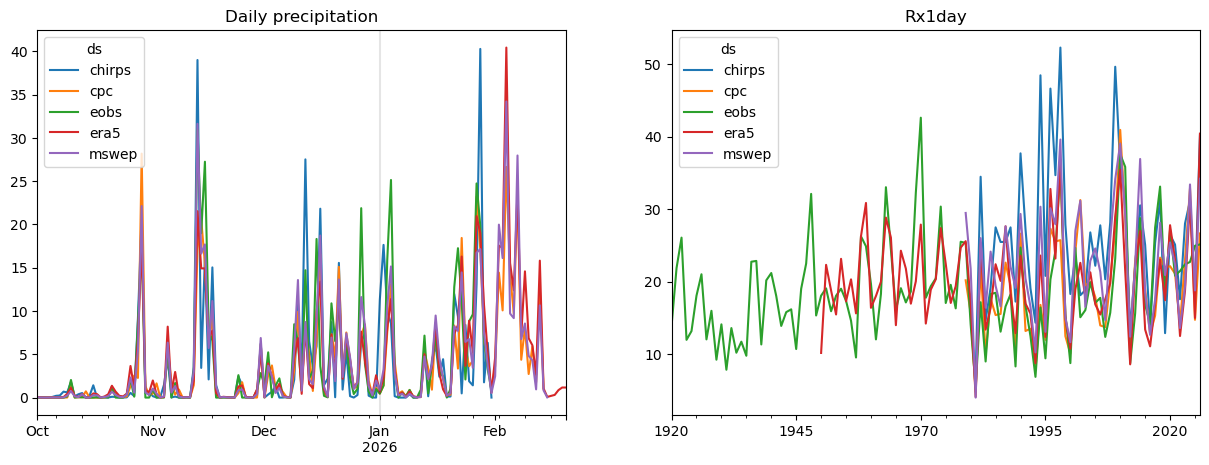

In [12]:
# CHIRPS frequently much higher magnitude in 80s-90s than either ERA5 or E-Obs
fig, axs = plt.subplots(ncols = 2, figsize = (15,5), dpi = 100)

ax = axs[0]
ts.sel(time = slice("2025-10","2026")).to_pandas().transpose().plot(ax = ax)
ax.axvline(datetime(2026,1,1), color = "k", alpha = 0.1)
ax.set_title("Daily precipitation")
ax.set_xlabel("")

ax = axs[1]
rx1day.to_pandas().transpose().plot(ax = ax)
ax.set_title("Rx1day")
ax.set_xlabel("")

plt.savefig("fig/obs-eval_timeseries.png")

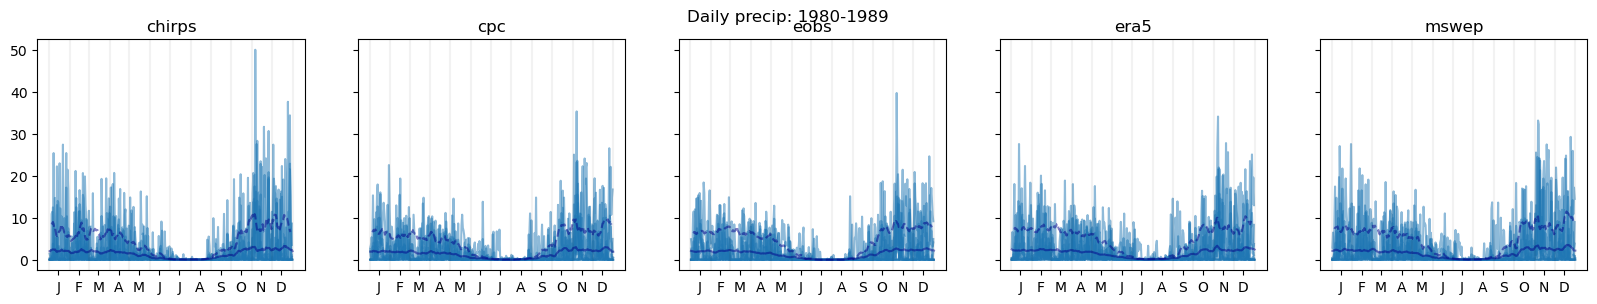

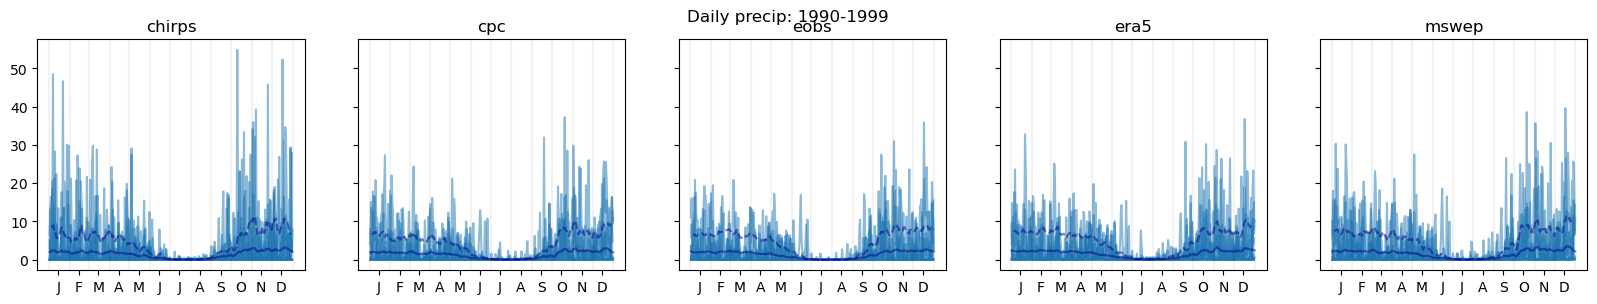

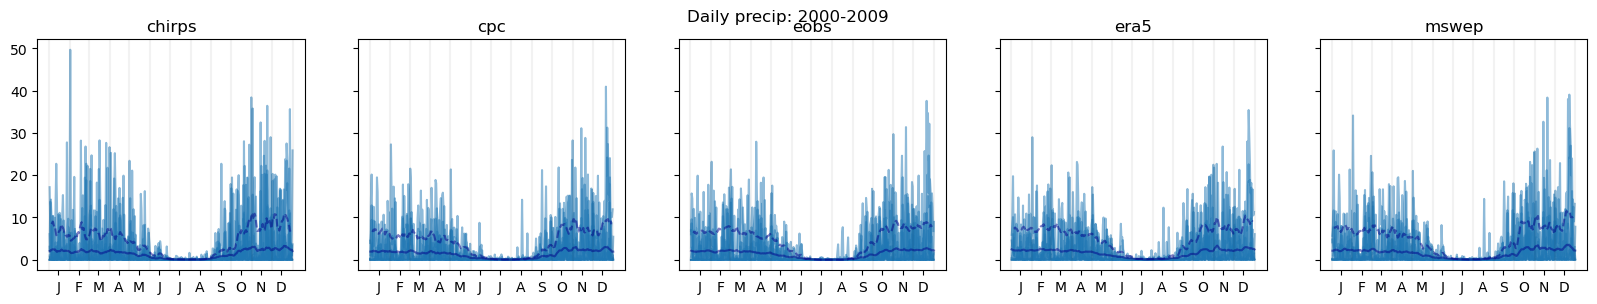

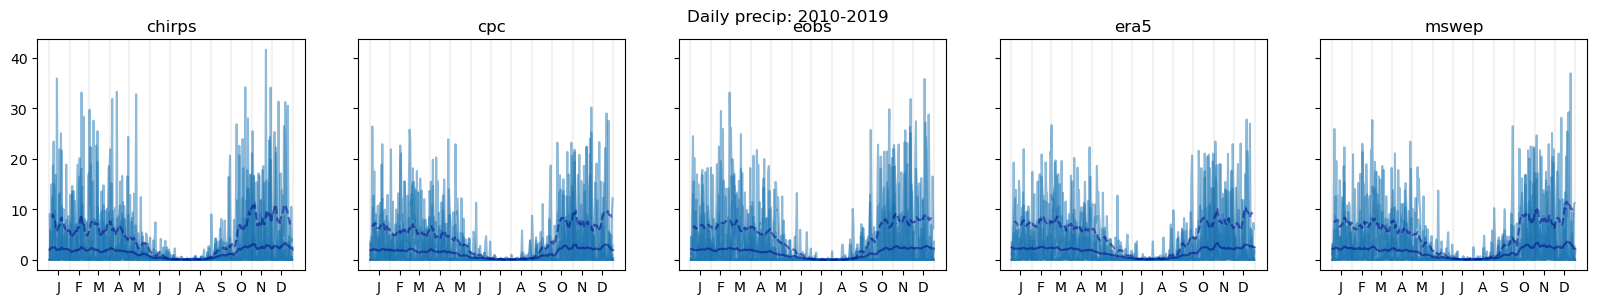

In [22]:
doy_offset = 0

days = pd.date_range(start = "2024-01-01", end = "2025-01-01")
labelticks = [i for i in range(len(days)) if (days[i].day) == 15]
labels = [days[i].strftime("%b")[0] for i in range(len(days)) if (days[i].day) == 15]

nc = len(ts.ds)
for ys in range(1980,2020,10):
    
    years = range(ys,ys+10)

    fig, axs = plt.subplots(ncols = nc, figsize = (nc*4,3), dpi = 100, sharey = True)

    for i in range(nc):
        ax = axs[i]
        x = ts.isel(ds = i).dropna("time")
        x = x.assign_coords(offset_time = ("time", [pd.Timestamp(t) + relativedelta(days = doy_offset) for t in x.time.values])) # shift time for offset axes
    
        for y in years:
            ts_y = x.sel(time = x.offset_time.dt.year == y)
            ax.plot(ts_y.offset_time.dt.dayofyear, ts_y, color = "tab:blue", alpha = 0.5, label = "_years")

        doy_mean = x.rolling(time = 7, center = True).mean().groupby("offset_time.dayofyear").mean()
        doy_q90 = x.groupby("offset_time.dayofyear").quantile(0.9).rolling(dayofyear = 7, center = True).mean()
        ax.plot(doy_mean.dayofyear, doy_mean, color = "darkblue", alpha = 0.5, label = "_years")
        ax.plot(doy_q90.dayofyear, doy_q90, color = "darkblue", alpha = 0.5, label = "_years", ls = "--")

        ax.set_xticks(labelticks)
        ax.set_xticklabels(labels)
        [ax.axvline(x, color = "k", alpha = 0.05) for x in range(len(days)) if (days[x].day) == 1]
        ax.set_title(x.ds.values)
    
    plt.suptitle("Daily precip: "+str(years[0])+"-"+str(years[-1]))
    
    plt.savefig("fig/obs-eval_"+str(years[0])+"-"+str(years[-1])+".png")

## Timing of annual maximum

In [30]:
rnm = "n"
ts = xr.concat([xr.open_dataset(fnm).expand_dims(ds = [fnm.split("_")[1][:-3]]) for fnm in sorted(glob.glob("data/pr-"+rnm+"_*.nc"))], "ds").pr

In [31]:
daymax = xr.concat([ts.sel(time = str(y), drop = True).idxmax("time").expand_dims(year = [y]) for y in range(1920,2027)], "year")
daymax_count = histogram(daymax.dt.month, bins = np.arange(0.5,13.5), dim = ["year"]).to_pandas().transpose()

daymax_count["order"] = list(range(7,13)) + list(range(1,7))
daymax_count = daymax_count.sort_values("order")

daymax_count = daymax_count / daymax_count.sum(axis = 0)

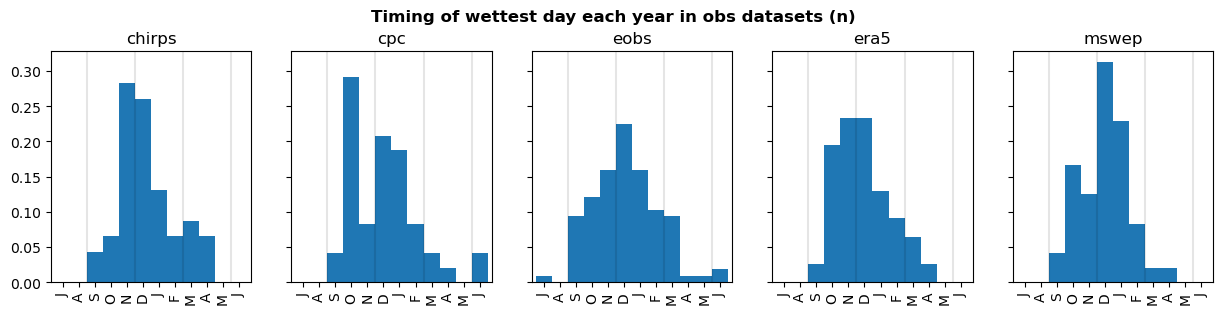

In [32]:
fig, axs = plt.subplots(ncols = 5, figsize = (15,3), sharey = True)

for i in range(5):
    ax = axs[i]
    daymax_count.iloc[:,i].plot(ax = ax, kind = "bar", width = 1)
    ax.set_title(daymax_count.columns[i])

    ax.set_xticklabels([datetime(2026,int(m),1).strftime("%b")[0] for m in daymax_count.index])
    ax.set_xlabel("")

    [ax.axvline(x, color = "k", alpha = 0.1) for x in np.arange(1.5,13.5, 3)]

plt.suptitle("Timing of wettest day each year in obs datasets ("+rnm+")", y = 1.02, fontweight = "bold")

plt.savefig("fig/wettest-day-timing_"+rnm+".png")

## Accumulations

In [ ]:
def y_offset(months): return datetime(2020,months,1).timetuple().tm_yday

In [37]:
rnm = "nportugal"
pr = eval("ts_"+rnm)

doy_offset = 0 #y_offset(5)
# pr.rolling(time = 91).sum().dropna("time").to_netcdf("pr-91day_"+rnm+"_era5land.nc")   # data for Tom
pr = pr.assign_coords(offset_time = ("time", [pd.Timestamp(t) + relativedelta(days = doy_offset) for t in pr.time.values])) # shift time for offset axes

days = pd.date_range(start = "2024-01-01", end = "2025-01-01")
# days = [d - relativedelta(days = doy_offset) for d in pd.date_range(start = "2026-01-01", end = "2027-01-01")]
labelticks = [i for i in range(len(days)) if (days[i].day) == 15]
labels = [days[i].strftime("%b")[0] for i in range(len(days)) if (days[i].day) == 15]

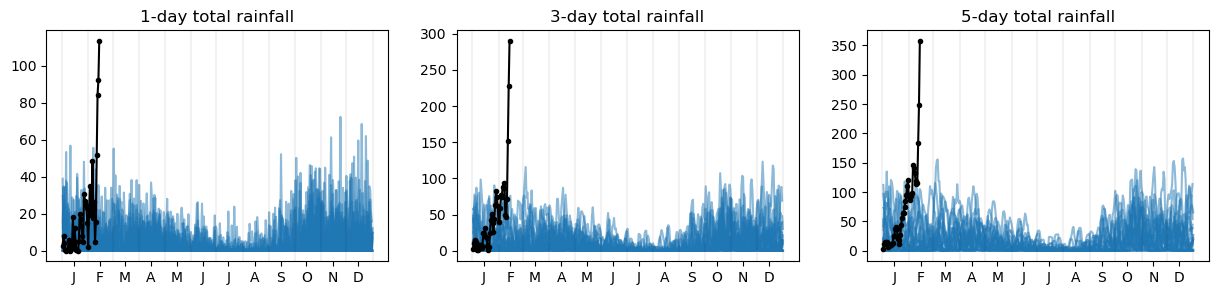

In [41]:
ndays = [1,3,5]

nc = 3; nr = int(np.ceil(len(ndays)/nc))
fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc*5, nr*3), dpi = 100, sharex = True)

for i in range(len(ndays)):
    ax = axs.flatten()[i]
    nd = ndays[i]

    ts = pr.rolling(time = nd).sum()

    y = 2026; ts_y = ts.sel(time = ts.offset_time.dt.year == y)
    ax.plot(ts_y.offset_time.dt.dayofyear, ts_y, color = "k", label = "2025", zorder = 99, marker = ".")
    
    for y in range(2000,2026):
        ts_y = ts.sel(time = ts.offset_time.dt.year == y)
        ax.plot(ts_y.offset_time.dt.dayofyear, ts_y, color = "tab:blue", alpha = 0.5, label = "_years")

    ax.set_xticks(labelticks)
    ax.set_xticklabels(labels)
    [ax.axvline(x, color = "k", alpha = 0.05) for x in range(len(days)) if (days[x].day) == 1]
    ax.set_title(str(nd)+"-day total rainfall")

    # ylim = ax.get_ylim()
    # if rnm == "chile2026":
    #     ax.add_patch(Rectangle((days.get_loc("2026-01-18"), 0), 3, ylim[1]+10, color = "gold", alpha = 0.3))
    # elif rnm == "patagonia":
    #     ax.add_patch(Rectangle((days.get_loc("2026-01-06"), 0), 21, ylim[1]+10, color = "gold", alpha = 0.3))
    # ax.set_ylim(ylim)

# plt.savefig("fig/expl_accumulated-pr_"+rnm+"_.png")